In [1]:
import tensorflow as tf
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.io import wavfile
import processing as pr
from tqdm.autonotebook import tqdm
from IPython import display

/tmp/ipykernel_3910754/2728358256.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
#data
model_name = "MSL"

In [3]:
train_set, test_set, label_set = pr.MSL()

100%|██████████| 81/81 [00:01<00:00, 68.48it/s]


In [4]:
if model_name == "SMD" or model_name == "SWaT":
    print("yes")
    train_set, test_set = pr.min_max(train_set, test_set)

In [5]:
train_set.shape

(138004, 25)

In [6]:
if model_name == "SMD" or model_name == "SWaT":
    train_set = pr.window_nonoverlap(train_set,100)
    test_copy = np.copy(test_set)
    test_set = pr.window_nonoverlap(test_set,100)
    label_set = pr.label_window(label_set,100)
else:
    train_set = pr.window_overlap(train_set,100)
    test_copy = np.copy(test_set)
    test_set = pr.window_overlap(test_set,100)

In [7]:
train_set.shape

(137905, 100, 25)

In [8]:
label_set.shape

(435826, 2)

In [9]:
seqs = train_set.shape[1]
channel = train_set.shape[-1]

In [10]:
def LSTM(seqs, channel):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((seqs,channel)))
    model.add(tf.keras.layers.LSTM(channel*2, return_sequences=True))
    model.add(tf.keras.layers.LSTM(channel*2, return_sequences=True))
    model.add(tf.keras.layers.LSTM(channel*2, return_sequences=True))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(channel)))
    return model

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

In [12]:
model = LSTM(seqs=seqs, channel=channel)
epochs = 50
batch_size = 128
for epoch in range(epochs):
	print("\nStart of epoch %d" % (epoch,))
	copy_set = np.copy(train_set)
	for k in tqdm(range(copy_set.shape[0]//batch_size), total=copy_set.shape[0]//batch_size):
		batch_mask = np.random.choice(copy_set.shape[0], batch_size, replace=False)
		batch = copy_set[batch_mask]
		with tf.GradientTape() as tape:
			input = tf.constant(batch, dtype='float32')
			prediction = model(input)
			reconstruction_error = mse_loss_fn(input,prediction)
			loss_value = reconstruction_error
		gradients = tape.gradient(loss_value, model.trainable_weights)
		optimizer.apply_gradients(zip(gradients, model.trainable_weights))
		if k % 100 == 0:
			print(
				"total loss at step %d: %.4f"
				% (k, float(tf.reduce_mean(loss_value)))
			)
		copy_set = np.delete(copy_set,batch_mask,axis=0)
	display.clear_output()


Start of epoch 11


  0%|          | 0/1077 [00:00<?, ?it/s]

total loss at step 0: 0.0001
total loss at step 100: 0.0001
total loss at step 200: 0.0001
total loss at step 300: 0.0001
total loss at step 400: 0.0001
total loss at step 500: 0.0000


In [ ]:
model.save('./model/LSTM_' + model_name)

In [ ]:
model = tf.keras.models.load_model('./model/LSTM_' + model_name)

In [18]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [19]:
test_set.shape

(73630, 100, 55)

In [20]:
label_set.shape

(73729, 2)

In [22]:
if model_name == "SMD" or  model_name == "SWaT":
    reconstruct_set = list()
    for i in tqdm(test_set):
        input = np.array([i])
        recon = model(input)
        reconstruct_set.extend(recon)
else:
    num = test_set.shape[0] // 100
    reconstruct_set = list()
    for i in tqdm(range(0,num)):
        i = test_set[i*100:(i+1)*100]
        recon = model(i)
        reconstruct_set.extend(recon)
    i = test_set[num*100:]
    recon = model(i)
    reconstruct_set.extend(recon)

  0%|          | 0/736 [00:00<?, ?it/s]

In [23]:
reconstruct_set = np.array(reconstruct_set)

In [24]:
reconstruct_set.shape

(73630, 100, 55)

In [25]:
pred = pr.pred(reconstruct_set)
pred.shape

(73729, 55)

In [26]:
recon_error = (pred-test_copy)**2
error_score = np.mean(recon_error,axis=1)
error_score.shape

(73729,)

In [19]:
recon_error = np.mean((reconstruct_set-test_set)**2, axis=1)

In [20]:
error_score = np.mean(recon_error, axis=-1)

In [21]:
error_score.shape

(4499,)

In [35]:
label_set = label_set[:,1]

In [37]:
label_set

array([0., 0., 0., ..., 0., 0., 0.])

In [38]:
score_set = error_score

In [39]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(label_set, score_set)

In [40]:
roc_auc = metrics.roc_auc_score(label_set, score_set)

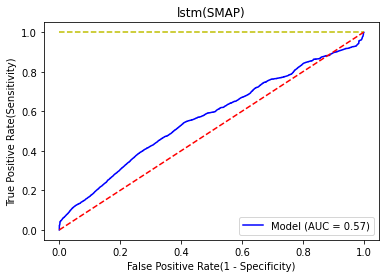

In [41]:
plt.title('lstm(' + model_name + ')')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model (AUC = %0.2f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.savefig('./graph/lstm_' + model_name + '.png', dpi=300)
plt.show()

In [42]:
train_set.shape

(58317, 55)